[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sensioai/blog/blob/master/013_perceptron2/perceptron2.ipynb)

# El Perceptrón (Parte 2)


![](https://www.researchgate.net/profile/Shibani_Singh2/publication/321141639/figure/fig2/AS:572731935727616@1513561342872/Schematic-of-Rosenblatts-perceptron.png)

Este modelo está inspirado en el funcionamiento de las neuronas biológicas que forman las redes neuronales de nuestros cerebros, recibiendo una serie de señales de entrada y devolviendo un resultado a la salida, calculando una suma ponderada de todos los *inputs* y aplicando una función de activación.

$$ \hat{y} = f(\mathbf{w} \cdot \mathbf{x}) = f(w_0 + w_1 x_1 + ... + w_m x_m) $$

También vimos cómo aplicar este sencillo algoritmo para la tarea de regresión lineal, en la que el objetivo es dar un valor numérico real a partir de una seria de características de entrada. Aprendimos que podemos encontrar los pesos $\mathbf{w}$ de nuestro modelo utilizando el algoritmo de optimización conocido como `descenso por gradiente` en el que minimizamos una `función de pérdida`. En este post vamos a ver el efecto que tienen sobre el proceso de entrenamiento (y por lo tanto en el resultado obtenido) los diferentes parámetros envueltos.

## El algoritmo de Descenso por Gradiente

Como vimos en el post anterior, el algoritmo de descenso por gradiente para el `Perceptrón` usando como función de pérdida el error medio cuadrático (*MSE*), se implementa de la forma siguiente:

1. Calcular la salida del modelo, $\hat{y}$.
2. Calcular la derivada de la función de pérdida con respecto a los parámetros del modelo, $\frac{\partial MSE}{\partial w} = \frac{2}{N} \frac{\partial \hat{y}}{\partial w} (\hat{y} - y) $ dónde $\frac{\partial \hat{y}}{\partial w} = x$.
3. Actualizar los parámetros, $w \leftarrow w - \eta \frac{\partial MSE}{\partial w}$, dónde $\eta$ es el *learning rate*.
4. Repetir hasta converger.

Inicializaremos nuestro modelo con unos valores aleatorios para los pesos, e iremos actualizando sus valores de manera iterativa en la dirección de pendiente negativa de la función de pérdida. Como puedes ver hay varios `hyperparámetros` en el proceso de optimización que van a afectar el proceso de optimización. Éstos son:

- Inicialización de los pesos
- Valor escogido del *learning rate*
- Datos utilizados para el cálculo del gradiente

Vamos a ver cómo afecta la elección de diferentes valores para estos parámetros.

> 💡 Llamamos `hyperparámetros` a todos aquellos parámetros que influyen en el resultado de la optimización pero que no son resultados de la misma (como los valores iniciales, *learning rate*, etc), mientras que los `parámetros` serían los resultados de la optimización (los pesos del modelo).

### Efectos de la inicialización

Vamos a ver cómo afecta al proceso de optimización la elección del valor inicial de los pesos. Para ello vamos a utilizar el mismo dataset sintético y funciones utilizadas en el post anterior.

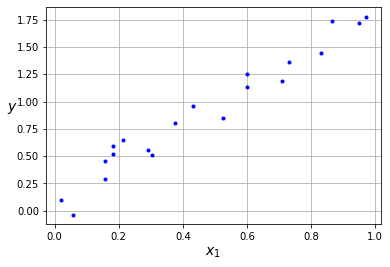

In [3]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

x = np.random.rand(20)
y = 2*x + (np.random.rand(20)-0.5)*0.5

plt.plot(x, y, "b.")
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$y$", rotation=0, fontsize=14)
plt.grid(True)
plt.show()

In [4]:
def gradient(w, x, y): 
    # calculamos la derivada de la función de pérdida
    # con respecto a los parámteros `w`
    dldw = x*w - y
    dydw = x
    dldw = dldw*dydw
    return np.mean(2*dldw)

def cost(y, y_hat): 
    # calculamos la función de pérdida
    return ((y_hat - y)**2).mean()

def solve(epochs = 29, w = 1.2, lr = 0.2):
    # iteramos un número determinado de `epochs`
    # por cada epoch, calculamos gradientes y 
    # actualizamos los pesos
    weights = [(w, gradient(w, x, y), cost(x*w, y))]
    for i in range(1,epochs+1):
        dw = gradient(w, x, y)
        w = w - lr*dw
        weights.append((w, dw, cost(x*w, y)))
    return weights

In [8]:
from matplotlib import animation, rc
rc('animation', html='html5')

def init_fig(x, t, ws, cost_ws):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
    ax2.plot(x, t, 'bo', label='y')
    ax2.set_xlim([0, 1])
    ax2.set_ylim([0, 2])
    ax2.set_xlabel('$x$', fontsize=15)
    ax2.set_ylabel('$y$', fontsize=15)
    ax2.yaxis.set_label_position('right')
    ax2.set_title('datos & modelo', fontsize=18)
    line2, = ax2.plot([], [], 'k-', label='$\hat{y}=x*w$')
    ax2.legend(loc=2)
    ax1.plot(ws, cost_ws, 'r-', label='MSE')
    ax1.set_ylim([0, 0.25])
    ax1.set_xlim([1, 2.75])
    ax1.set_xlabel('$w$', fontsize=15)
    ax1.set_ylabel('$MSE = 1 / N \sum (\hat{y}-y)^2$', fontsize=15)
    cost_text = ax1.set_title('$MSE_{}$'.format(0), fontsize=18)
    line1, = ax1.plot([], [], 'k:', label='derivada en $w$')
    pc_dots, = ax1.plot([], [], 'ko')
    ax1.legend(loc=2)
    ax1.grid(True)
    ax2.grid(True)
    return fig, ax1, ax2, line1, line2, pc_dots, cost_text

def get_anim(fig, ax1, ax2, line1, line2, pc_dots, cost_text, weights):
    xs = np.linspace(0, 4, num=100) 
    def anim(i):
        if i == 0:
            return [line1, line2, pc_dots, cost_text]
        (w, dw, cost) = weights[i-1]
        cost_text.set_text('$MSE_{{{}}} = {:.3f}$'.format(i, cost))
        ws, _, cs = zip(*weights[0:i])
        pc_dots.set_xdata(ws)
        pc_dots.set_ydata(cs)
        abline_values = [dw * (x-w) + cost for x in xs]
        line1.set_xdata(xs)
        line1.set_ydata(abline_values)
        # Plot fit
        # plot the fitted line
        line2.set_xdata([0, 1])
        line2.set_ydata([0*w, 1*w])
        ax2.legend(loc=2)
        return [line1, line2, pc_dots, cost_text]
    return anim

ws = np.linspace(0, 4, num=100)  
cost_ws = np.vectorize(lambda w: cost(x*w, y))(ws)  
fig, ax1, ax2, line1, line2, pc_dots, cost_text = init_fig(x, y, ws, cost_ws)

def compute_anim(weights):
    animate = get_anim(fig, ax1, ax2, line1, line2, pc_dots, cost_text, weights)
    anim = animation.FuncAnimation(fig, animate, frames=len(weights)+1, interval=200, blit=True)
    plt.close()
    return anim

weights = solve(w = 1.2)
anim = compute_anim(weights)
anim

En el primer ejemplo utilizamos el mismo valor inicial que vimos en el post anterior. En cada iteración calculamos la derivada de la función de pérdida con respecto al peso del modelo, la cual nos indicará la dirección en la que tenemos que actualizar su valor para reducir el error. Repetimos el proceso por un número determinado de iteraciones (*epochs*).

In [5]:
fig, ax1, ax2, line1, line2, pc_dots, cost_text = init_fig(x, y, ws, cost_ws)
weights = solve(w = 1.6)
anim = compute_anim(weights)
anim

En el siguiente ejemplo vemos el efecto que tiene utilizar un valor de inicialización más cercano al valor óptimo. Cómo podemos ver, en este caso llegamos al valor óptimo más rápido, en menos *epochs*. Es común inicializar estos pesos de manera aleatoria (quizás siguiendo una distribución de probabilidad determinada). Así pues, si tenemos suerte y los valores iniciales están cercanos al óptimo el proceso de optimización necesitará menos iteraciones y por lo tanto será más rápido (o para el mismo número de iteraciones tendremos un mejor resultado).

In [6]:
fig, ax1, ax2, line1, line2, pc_dots, cost_text = init_fig(x, y, ws, cost_ws)
weights = solve(w = 5)
anim = compute_anim(weights)
anim

En el último ejemplo utilizamos un valor más alejado del óptimo, cómo podríamos esperar necesitamos más iteraciones para acercarnos al valor óptimo. 

Cómo hemos podido ver la inicialización de nuestro modelo tendrá un efecto en el proceso de optimización, principalmente en el número de iteraciones que necesitaremos para llegar al valor óptimo. Sin embargo, debido a que el algoritmo de descenso por gradiente no nos garantiza encontrar el valor óptimo global y puede quedarse "atascado" en un valor óptimo local, es común realizar múltiples optimizaciones con diferentes valores iniciales.

![](https://www.monografias.com/trabajos95/redes-neuronales-artificiales-metodologia-desarrollo-y-aplicaciones/image010.jpg)

### Efectos del *learning rate*

En esta sección vemos cómo afecta el valor escogido del *learning rate* al proceso de optimización. Para ello usarmos el mismo valor inicial en todos los casos.

In [7]:
fig, ax1, ax2, line1, line2, pc_dots, cost_text = init_fig(x, y, ws, cost_ws)
weights = solve(lr = 0.2)
anim = compute_anim(weights)
anim

En el primer caso utilizamos un valor de $\eta = 0.2$ y podemos ver como llegamos a la solución óptima poco a poco.

In [8]:
fig, ax1, ax2, line1, line2, pc_dots, cost_text = init_fig(x, y, ws, cost_ws)
weights = solve(lr = 0.01)
anim = compute_anim(weights)
anim

Un valor muy pequeño nos sigue llevando a la solución óptima, pero requiriendo de muchas iteraciones.

In [9]:
fig, ax1, ax2, line1, line2, pc_dots, cost_text = init_fig(x, y, ws, cost_ws)
weights = solve(lr = 1)
anim = compute_anim(weights)
anim

En el caso anterior utilizamos un valor más grande de $\eta = 1$ y observamos como llegamos a la solución óptima mucho más rápido, en apenas 5 iteraciones mientras que en el caso anterior necesitábamos 30. Recordemos que los pesos los actualizamos siguiendo la ecuación $w \leftarrow w - \eta \frac{\partial MSE}{\partial w}$ por lo que el *learning rate* determinará como de grande será el paso que daremos en cada iteración en dirección al valor óptimo.

In [10]:
fig, ax1, ax2, line1, line2, pc_dots, cost_text = init_fig(x, y, ws, cost_ws)
weights = solve(lr = 3)
anim = compute_anim(weights)
anim

Sin embargo, si utilizamos un valor demasiado grande podemos observar que en vez de acelerar el proceso de optimización se realentiza, necesitando más iteraciones para llegar al valor óptimo. Aún así, vemos que el proceso converge.

In [11]:
fig, ax1, ax2, line1, line2, pc_dots, cost_text = init_fig(x, y, ws, cost_ws)
weights = solve(w = 1.8, lr = 3.5)
anim = compute_anim(weights)
anim

Cuando utilizamos un valor demasiado grande, el proceso de optimización no puede converger ya que los pasos que damos son muy grandes consiguiendo justo el efecto contrario: en vez de dar pasos hacia el valor óptimo nos alejamos de él. Incluso si nuestra inicialización es buena, un *learning rate* grande será perjudicial.

Hemos visto el efecto que tiene el *learning rate* en el entrenamiento de nuesto `Perceptrón`. Un valor muy pequeño resulta en un proceso de optimización lento, mientras que un valor muy grande hará que el proceso sea divergente. Así pues tendremos que utilizar valores adecuados para tener una optimización rápida y convergente. Lamentablemente un valor "muy pequeño" o "muy grande" o "adecuado" va a depender de la función de pérdida y modelo utilizados, por lo que cada caso requerirá de varias pruebas para encontrar el mejor valor de *learning rate*. 

![](https://miro.medium.com/max/918/0*uIa_Dz3czXO5iWyI.)

### Variantes del Descenso por Gradiente

En todos los casos anteriores hemos utilizado todos los elementos del dataset en el cálculo del gradiente. Esto se conoce como `Batch Gradient Descent` y su principal limitación es aquellos casos en los que el conjunto de datos es tan grande que no cabe en la memoria del ordenador. En estos casos tenemos dos alternativas. En el caso diametralmente opuesto, `Stochastic Gradient Descent` calcula la derivada por cada elemento del dataset de manera independiente. Aún así, la opción más utilizada es `Mini-Batch Gradient Descent`, método en el que usaremos un pequeño conjunto de los datos para calcular la derivada de la función de pérdida en cada iteración.

#### Stochastic Gradient Descent

In [7]:
def solve_sgd(epochs = 5, w = 1.2, lr = 0.2):
    # stochastic gradient descent
    weights = [(w, gradient(w, x, y), cost(x*w, y))]
    for i in range(1,epochs+1):
        # un update por cada elemento del dataset
        for _x, _y in zip(x, y):
            dw = gradient(w, _x, _y)
            w = w - lr*dw
            weights.append((w, dw, cost(_x*w, _y)))
    return weights

In [9]:
fig, ax1, ax2, line1, line2, pc_dots, cost_text = init_fig(x, y, ws, cost_ws)
weights = solve_sgd()
anim = compute_anim(weights)
anim

Este algoritmo es capaz de converger, pero en esta variante el proceso de optimización es errático, ya que la estimación del gradiente varía mucho de un punto a otro.

#### Mini-Batch Gradient Descent

In [13]:
def solve_mbgd(epochs = 20, w = 1.2, lr = 0.2, batch_size=10):
    # mini-batch gradient descent
    batches = len(x) // batch_size
    weights = [(w, gradient(w, x, y), cost(x*w, y))]
    for i in range(1,epochs+1):
        # un update por cada `batch`
        for j in range(batches):
            _x = x[j*batch_size:(j+1)*batch_size]
            _y = y[j*batch_size:(j+1)*batch_size]
            dw = gradient(w, _x, _y)
            w = w - lr*dw 
            # Guardar grupo de baches por iteracion
            weights.append((w, dw, cost(_x*w, _y)))
    return weights

In [14]:
fig, ax1, ax2, line1, line2, pc_dots, cost_text = init_fig(x, y, ws, cost_ws)
weights = solve_mbgd()
anim = compute_anim(weights)
anim

En este caso observamos un comportamiento intermedio entre utilizar todos los datos para hacer un paso de optimización o un solo elemento del dataset. El proceso sigue convergiendo, no de manera tan suave como en la variante `Batch Gradient Descent`, sigue siendo un poco errático, pero no tanto como la variante `Stochastic Gradient Descent`. Este hecho hace que sea la opción por defecto en la mayoría de procesos de optimización. 

> ⚡ Una implementación en modo *mini batch* siempre nos permitirá utilizar la variante *batch* o *stochastic* simplemente usando un *batch size* igual al número de elementos del dataset para el primer caso o igual a 1 para el segundo.

![](https://suniljangirblog.files.wordpress.com/2018/12/descent.png?w=908)